Name: **Om Jain**<br>
Div: **BE10-Q10**<br>
Roll no: **43231**<br>
Title: **Assignment 6: Object detection using Transfer Learning of CNN architectures**<br>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Importing all the necessary libraries

from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns
# PyTorch
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data science tools
import numpy as np
import pandas as pd
import os

# Image manipulations
from PIL import Image
# Useful for examining network
from torchsummary import summary
# Timing utility
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

# Printing out all outputs
InteractiveShell.ast_node_interactivity = 'all'

In [5]:
# Location of data
datadir = '/content/drive/MyDrive/Deep learning assignment/'
traindir = datadir + 'train/'
validdir = datadir + 'valid/'
testdir = datadir + 'test/'

save_file_name = 'vgg16-transfer-4.pt'
checkpoint_path = 'vgg16-transfer-4.pth'

# Change to fit hardware
batch_size = 128

# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

multi_gpu = False

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: False


In [6]:
#Liiking at the number of images in each category and the size of the images

# Empty lists
categories = []
img_categories = []
n_train = []
n_valid = []
n_test = []
hs = []
ws = []

# Iterate through each category
for d in os.listdir(traindir):
    categories.append(d)

    # Number of each image
    train_imgs = os.listdir(traindir + d)
    valid_imgs = os.listdir(validdir + d)
    test_imgs = os.listdir(testdir + d)
    n_train.append(len(train_imgs))
    n_valid.append(len(valid_imgs))
    n_test.append(len(test_imgs))

    # Find stats for train images
    for i in train_imgs:
        img_categories.append(d)
        img = Image.open(traindir + d + '/' + i)
        img_array = np.array(img)
        # Shape
        hs.append(img_array.shape[0])
        ws.append(img_array.shape[1])

# Dataframe of categories
cat_df = pd.DataFrame({'category': categories,
                       'n_train': n_train,
                       'n_valid': n_valid, 'n_test': n_test}).\
    sort_values('category')

# Dataframe of training images
image_df = pd.DataFrame({
    'category': img_categories,
    'height': hs,
    'width': ws
})

cat_df.sort_values('n_train', ascending=False, inplace=True)
cat_df.head()
cat_df.tail()

category  n_train  n_valid  n_test
9   leopards      200       52      52
7  butterfly       91       60      60
4    dolphin       65       37      37
2   elephant       64       24      24
5  crocodile       50       26      26

category  n_train  n_valid  n_test
1  cougar_body       47       31      31
8       beaver       46       18      18
3          ant       42       26      26
6        panda       38       26      26
0      octopus       35       19      19

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Training Images by Category')

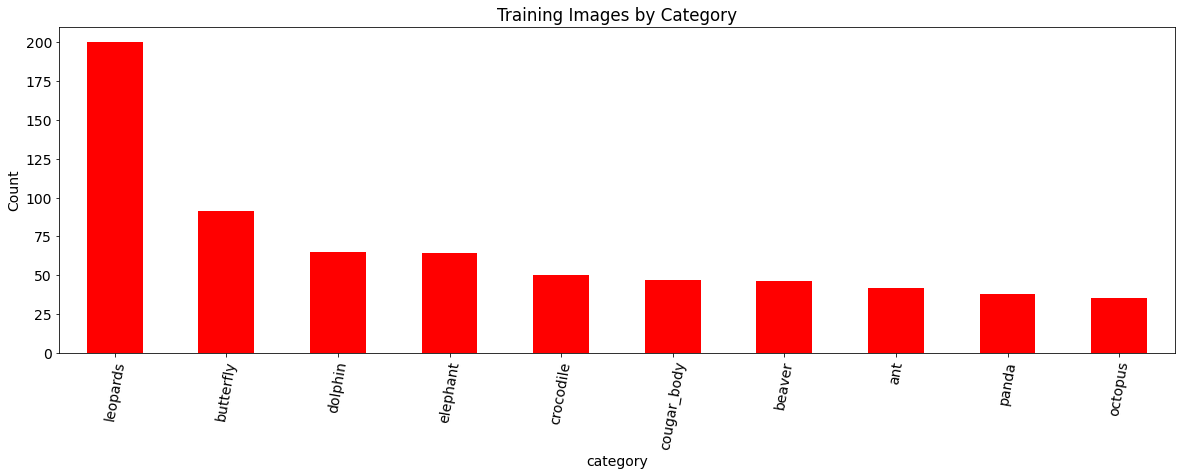

In [7]:
#Distribution of images
cat_df.set_index('category')['n_train'].plot.bar(
    color='r', figsize=(20, 6))
plt.xticks(rotation=80)
plt.ylabel('Count')
plt.title('Training Images by Category')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Training Images by Category')

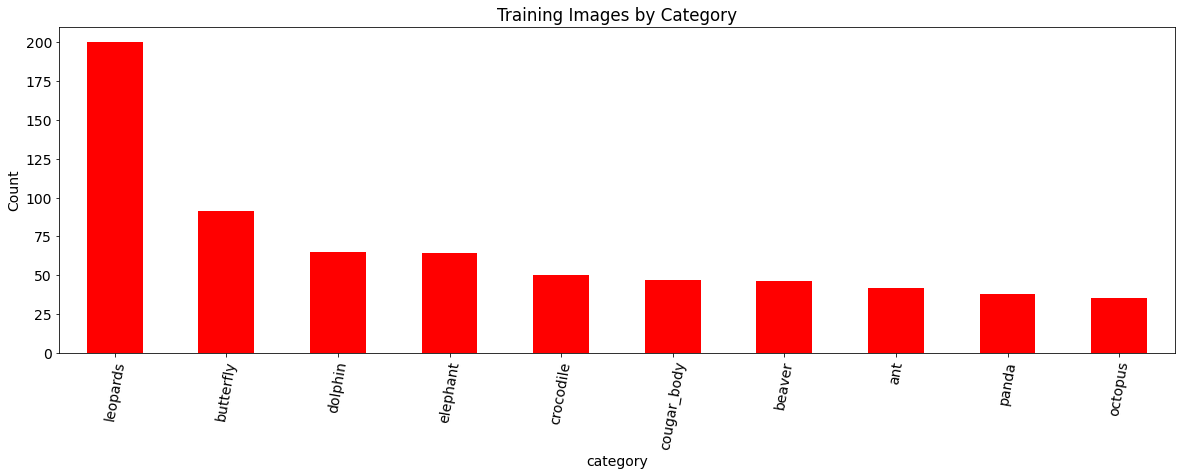

In [8]:
# Only top 50 categories
cat_df.set_index('category').iloc[:50]['n_train'].plot.bar(
    color='r', figsize=(20, 6))
plt.xticks(rotation=80)
plt.ylabel('Count')
plt.title('Training Images by Category')

In [9]:
#Distribution of Images sizes
img_dsc = image_df.groupby('category').describe()
img_dsc.head()

height                                                       \
             count        mean        std    min     25%    50%     75%   
category                                                                  
ant           42.0  212.285714  43.884708  103.0  178.75  209.5  238.25   
beaver        46.0  221.826087  42.358420  153.0  193.25  214.0  240.75   
butterfly     91.0  246.538462  37.842747  178.0  216.00  248.0  278.00   
cougar_body   47.0  237.489362  52.251429  133.0  196.50  226.0  300.00   
crocodile     50.0  180.660000  36.069440  115.0  157.00  180.5  200.00   

                   width                                                     \
               max count        mean        std    min    25%    50%    75%   
category                                                                      
ant          300.0  42.0  299.333333   4.165284  273.0  300.0  300.0  300.0   
beaver       300.0  46.0  296.760870  13.011422  215.0  300.0  300.0  300.0   
butterfly    300.0  91.0  296.637363  14.231824  211.0  300.0  300.0  300.0   
cougar_body  300.0  47.0  285.446809  27.992086  204.0  288.5  300.0  300.0   
crocodile    296.0  50.0  299.980000   0.141421  299.0  300.0  300.0  300.0   

                    
               max  
category            
ant          300.0  
beaver       300.0  
butterfly    300.0  
cougar_body  300.0  
crocodile    300.0

<Figure size 720x432 with 0 Axes>

Text(0.5, 0, 'Pixels')

Text(0, 0.5, 'Density')

Text(0.5, 1.0, 'Average Size Distribution')

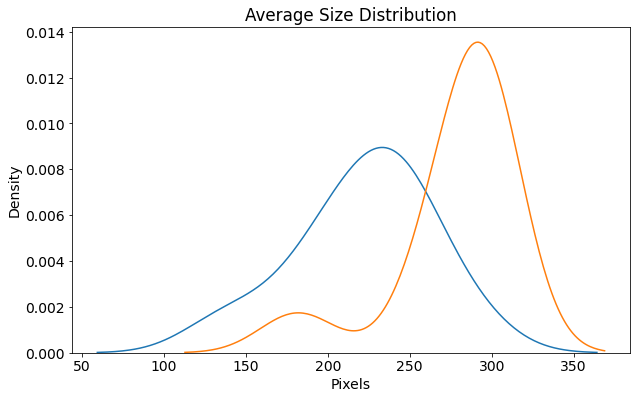

In [10]:
plt.figure(figsize=(10, 6))
sns.kdeplot(
    img_dsc['height']['mean'], label='Average Height')
sns.kdeplot(
    img_dsc['width']['mean'], label='Average Width')
plt.xlabel('Pixels')
plt.ylabel('Density')
plt.title('Average Size Distribution')

In [11]:
#When we use the images in the pre-trained network, we'll have to reshape them to 224 x 224. This is the size of Imagenet images and is therefore what the model expects. The images that are larger than this will be truncated while the smaller images will be interpolated. 

(264, 300, 3)

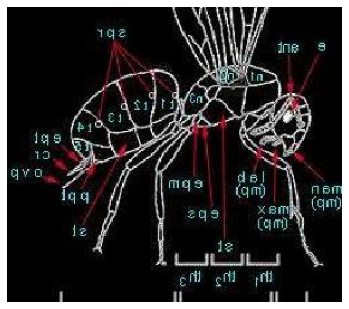

In [12]:
def imshow(image):
    """Display image"""
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()


# Example image
x = Image.open(traindir + 'ant/image_0017.jpg')
np.array(x).shape
imshow(x)

In [13]:
# Data Augmentation and Image transformations


image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [14]:
def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

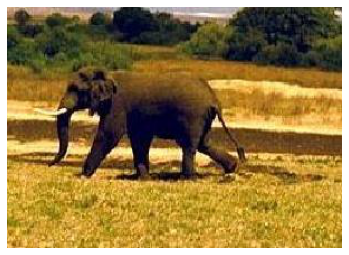

In [15]:
ex_img = Image.open(datadir + 'train/elephant/image_0024.jpg')
imshow(ex_img)

<Figure size 1728x1728 with 0 Axes>

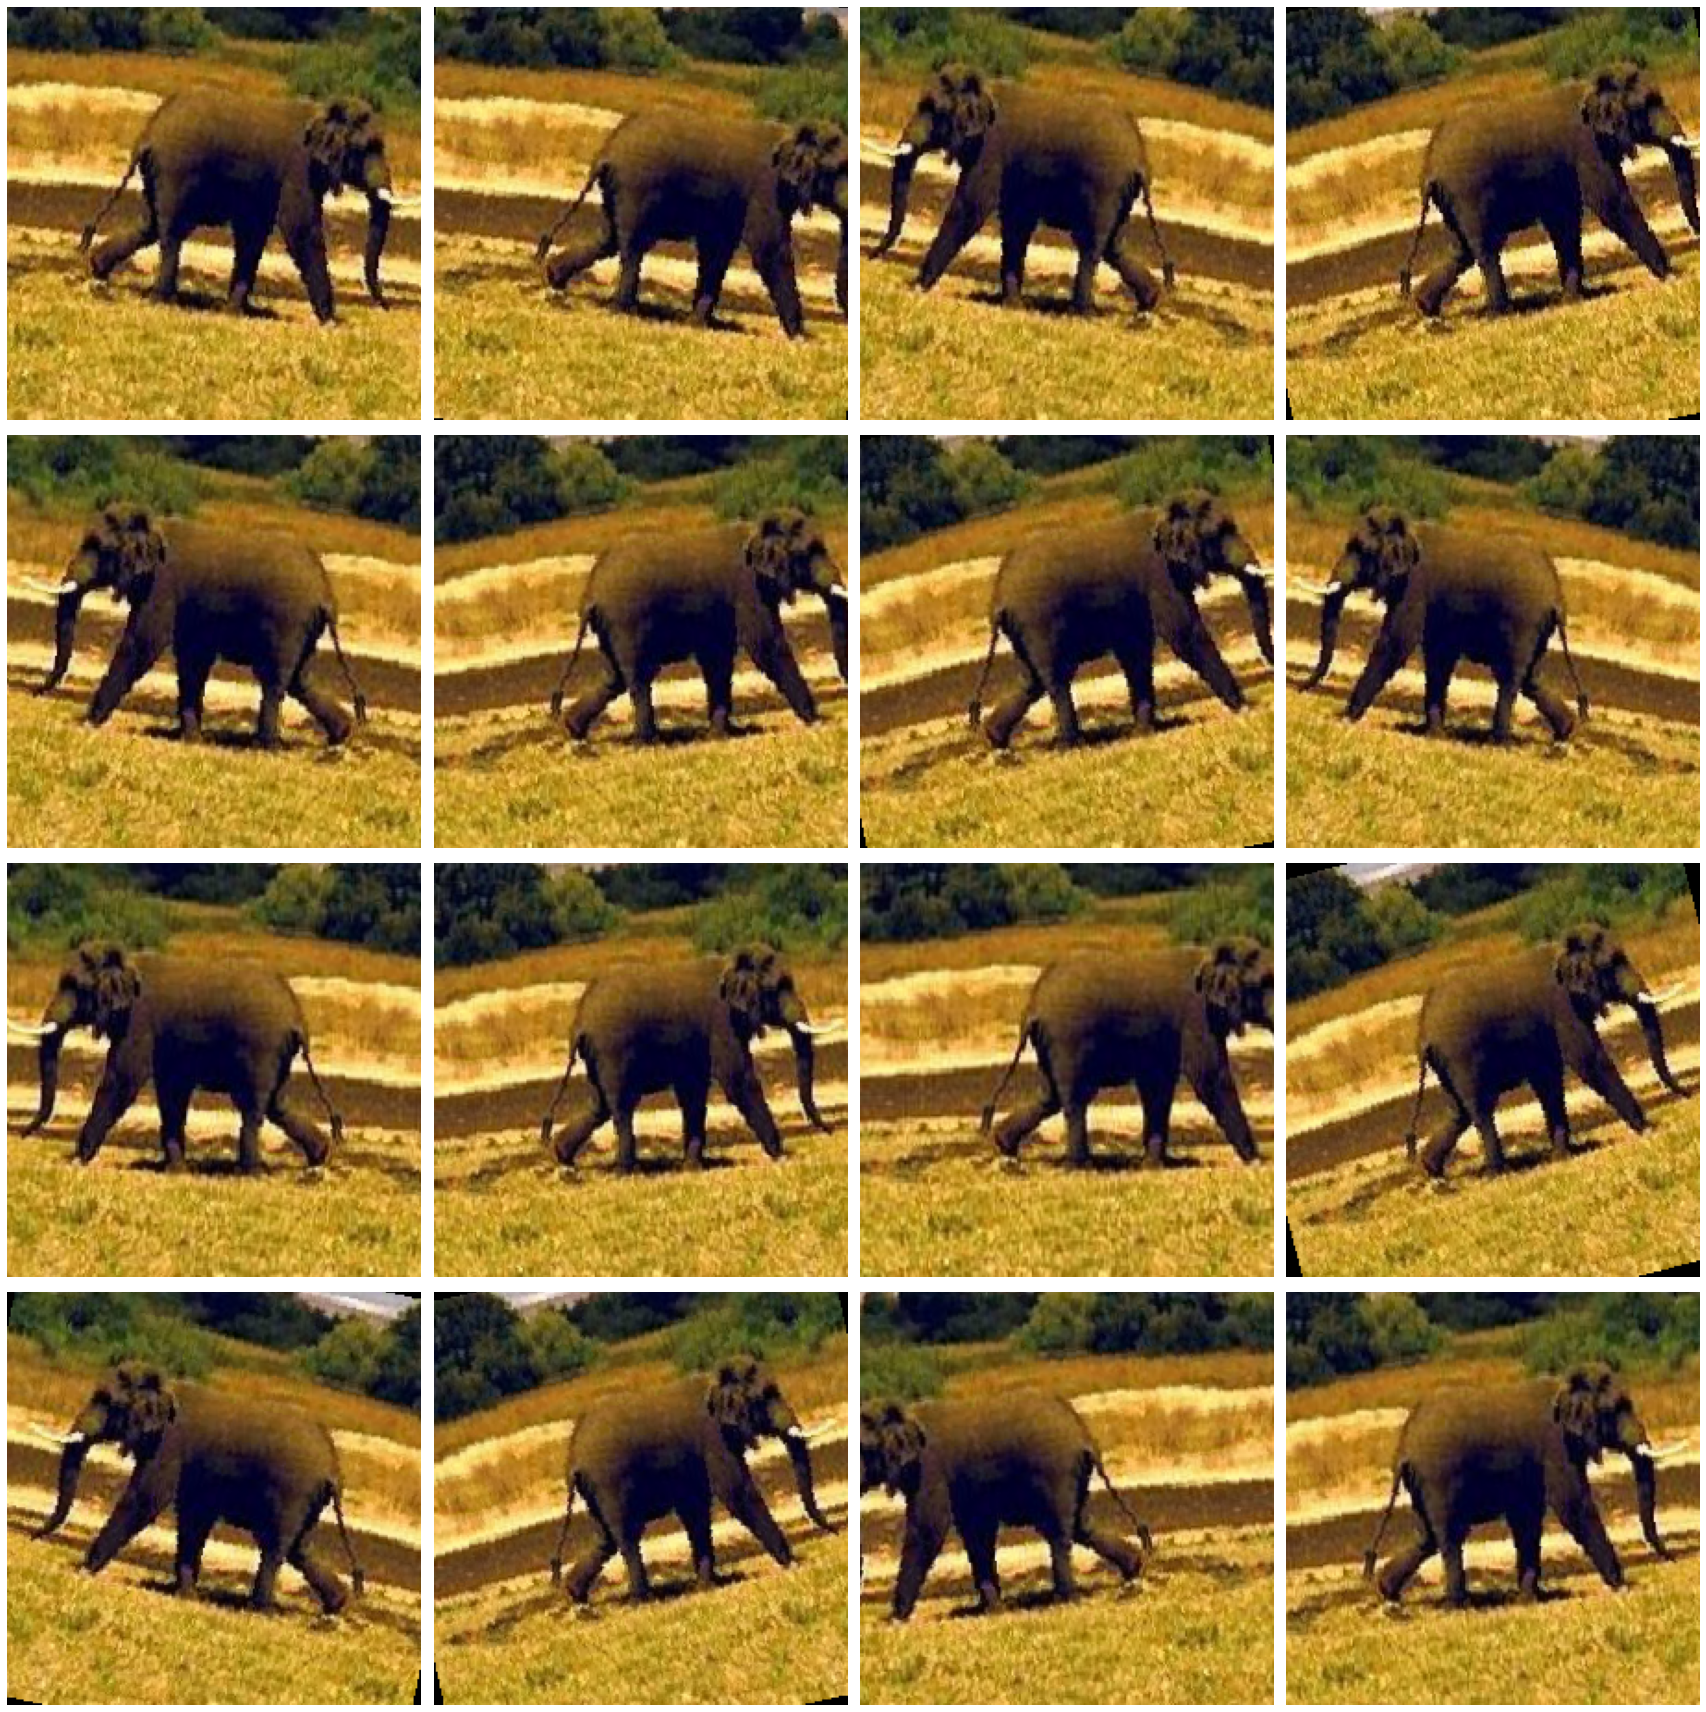

In [16]:
t = image_transforms['train']
plt.figure(figsize=(24, 24))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    _ = imshow_tensor(t(ex_img), ax=ax)

plt.tight_layout()

In [17]:
#Using dataloaders for speedy iterations
'''This construction avoids the need to load all the data into memory and also will automatically apply the transformations to each batch. On each epoch, the Random transformations will be different so the network will essentially see multiple versions of each training image.'''

# Datasets from each folder
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=validdir, transform=image_transforms['val']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}

# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}

'This construction avoids the need to load all the data into memory and also will automatically apply the transformations to each batch. On each epoch, the Random transformations will be different so the network will essentially see multiple versions of each training image.'

In [18]:
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

In [19]:
n_classes = len(cat_df)
print(f'There are {n_classes} different classes.')

len(data['train'].classes)

There are 10 different classes.


10

In [20]:
#using the pre-trained model -vgg for first few convolutional trained layers
model = models.vgg16(pretrained=True)
model

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [21]:
#manual training to be done only on classifier layer. rest as it is

In [22]:
# Freeze early layers
for param in model.parameters():
    param.requires_grad = False

In [23]:
'''train a classifier consisting of the following layers

Fully connected with ReLU activation (n_inputs, 256)
Dropout with 40% chance of dropping
Fully connected with log softmax output (256, n_classes)'''

n_inputs = model.classifier[6].in_features

# Add on classifier
model.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.4),
    nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

model.classifier

'train a classifier consisting of the following layers\n\nFully connected with ReLU activation (n_inputs, 256)\nDropout with 40% chance of dropping\nFully connected with log softmax output (256, n_classes)'

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=10, bias=True)
    (4): LogSoftmax(dim=1)
  )
)

In [24]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

135,311,946 total parameters.
1,051,402 training parameters.


In [25]:
#moving to gpu
if train_on_gpu:
    model = model.to('cuda')

if multi_gpu:
    model = nn.DataParallel(model)

In [26]:
#function to load in pretrained model
def get_pretrained_model(model_name):
    """Retrieve a pre-trained model from torchvision

    Params
    -------
        model_name (str): name of the model (currently only accepts vgg16 and resnet50)

    Return
    --------
        model (PyTorch model): cnn

    """

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)

        # Freeze early layers
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features

        # Add on classifier
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False

        n_inputs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

    # Move to gpu and parallelize
    if train_on_gpu:
        model = model.to('cuda')

    if multi_gpu:
        model = nn.DataParallel(model)

    return model

In [27]:
model = get_pretrained_model('vgg16')
if multi_gpu:
    summary(
        model.module,
        input_size=(3, 224, 224),
        batch_size=batch_size,
        device='cuda')
else:
    summary(
        model, input_size=(3, 224, 224), batch_size=batch_size, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 64, 224, 224]           1,792
              ReLU-2        [128, 64, 224, 224]               0
            Conv2d-3        [128, 64, 224, 224]          36,928
              ReLU-4        [128, 64, 224, 224]               0
         MaxPool2d-5        [128, 64, 112, 112]               0
            Conv2d-6       [128, 128, 112, 112]          73,856
              ReLU-7       [128, 128, 112, 112]               0
            Conv2d-8       [128, 128, 112, 112]         147,584
              ReLU-9       [128, 128, 112, 112]               0
        MaxPool2d-10         [128, 128, 56, 56]               0
           Conv2d-11         [128, 256, 56, 56]         295,168
             ReLU-12         [128, 256, 56, 56]               0
           Conv2d-13         [128, 256, 56, 56]         590,080
             ReLU-14         [128, 256,

In [28]:
if multi_gpu:
    print(model.module.classifier[6])
else:
    print(model.classifier[6])

Sequential(
  (0): Linear(in_features=4096, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=256, out_features=10, bias=True)
  (4): LogSoftmax(dim=1)
)


In [29]:
#mapping of classes to indexes

model.class_to_idx = data['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())[:10]

[(0, 'ant'),
 (1, 'beaver'),
 (2, 'butterfly'),
 (3, 'cougar_body'),
 (4, 'crocodile'),
 (5, 'dolphin'),
 (6, 'elephant'),
 (7, 'leopards'),
 (8, 'octopus'),
 (9, 'panda')]

In [30]:
criterion = nn.NLLLoss() #keeps track of the loss itself and the gradients of the loss with respect to the model parameters (weights)
optimizer = optim.Adam(model.parameters()) #updates the parameters (weights) with the gradients

In [31]:
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

torch.Size([256, 4096])
torch.Size([256])
torch.Size([10, 256])
torch.Size([10])


In [32]:
#Training

def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=2,
          print_every=2):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [33]:
model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=2,
    print_every=2)

Starting Training from Scratch.


Epoch: 1 	Training Loss: 0.3858 	Validation Loss: 0.1753
		Training Accuracy: 90.71%	 Validation Accuracy: 94.36%

Best epoch: 1 with loss: 0.18 and acc: 94.36%
1024.50 total seconds elapsed. 1024.50 seconds per epoch.


<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

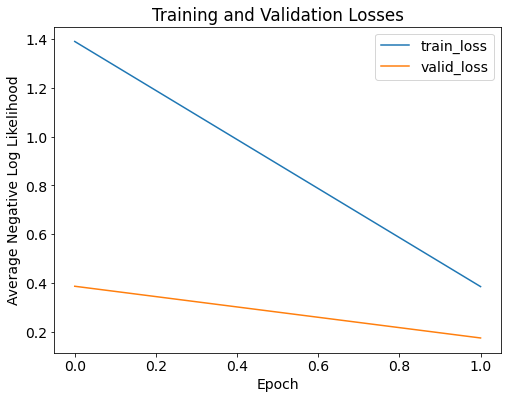

In [34]:
#Training results shown graphically

plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

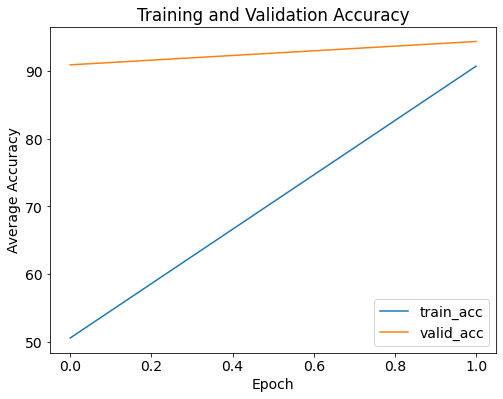

In [35]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

In [36]:
#The accuracy cones out to be >80%

In [37]:
'''This function processes an image path into a PyTorch tensor for predictions. It applies the same transformations as was done to the validation data: cropping (center) and normalizing with means and standard deviations.'''

def process_image(image_path):
    """Process an image path into a PyTorch tensor"""

    image = Image.open(image_path)
    # Resize
    img = image.resize((256, 256))

    # Center crop
    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    img = img.crop((left, top, right, bottom))

    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img).transpose((2, 0, 1)) / 256

    # Standardization
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)

    return img_tensor

'This function processes an image path into a PyTorch tensor for predictions. It applies the same transformations as was done to the validation data: cropping (center) and normalizing with means and standard deviations.'

In [38]:
x = process_image(testdir + 'leopards/image_0041.jpg')
x.shape

torch.Size([3, 224, 224])

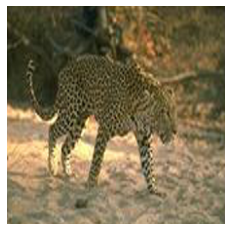

In [39]:
ax, image = imshow_tensor(x)

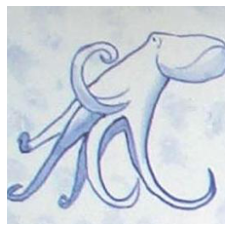

In [40]:
ax, image = imshow_tensor(process_image(testdir + 'octopus/image_0035.jpg'))

In [41]:
#Fucntion to make predictions

def predict(image_path, model, topk=5):
    """Make a prediction for an image using a trained model

    Params
    --------
        image_path (str): filename of the image
        model (PyTorch model): trained model for inference
        topk (int): number of top predictions to return

    Returns

    """
    real_class = image_path.split('/')[-2]

    # Convert to pytorch tensor
    img_tensor = process_image(image_path)

    # Resize
    if train_on_gpu:
        img_tensor = img_tensor.view(1, 3, 224, 224).cuda()
    else:
        img_tensor = img_tensor.view(1, 3, 224, 224)

    # Set to evaluation
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(img_tensor)
        ps = torch.exp(out)

        # Find the topk predictions
        topk, topclass = ps.topk(topk, dim=1)

        # Extract the actual classes and probabilities
        top_classes = [
            model.idx_to_class[class_] for class_ in topclass.cpu().numpy()[0]
        ]
        top_p = topk.cpu().numpy()[0]

        return img_tensor.cpu().squeeze(), top_p, top_classes, real_class

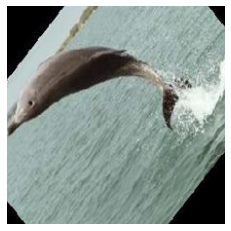

In [42]:
np.random.seed = 100


def random_test_image():
    """Pick a random test image from the test directory"""
    c = np.random.choice(cat_df['category'])
    root = testdir + c + '/'
    img_path = root + np.random.choice(os.listdir(root))
    return img_path


_ = imshow_tensor(process_image(random_test_image()))

In [43]:
img, top_p, top_classes, real_class = predict(random_test_image(), model)
img.shape

torch.Size([3, 224, 224])

In [44]:
top_p, top_classes, real_class

(array([9.9993932e-01, 3.5283025e-05, 8.9764435e-06, 7.7069881e-06,
        5.1496277e-06], dtype=float32),
 ['panda', 'octopus', 'ant', 'butterfly', 'beaver'],
 'panda')

In [45]:
img, top_p, top_classes, real_class = predict(random_test_image(), model)
top_p, top_classes, real_class

(array([9.9641907e-01, 2.1307915e-03, 4.4392780e-04, 4.2834345e-04,
        2.2905838e-04], dtype=float32),
 ['dolphin', 'octopus', 'elephant', 'butterfly', 'beaver'],
 'dolphin')

In [46]:
#function to display predictions. some predicted classes are shown but title seems to be the true class

def display_prediction(image_path, model, topk):
    """Display image and preditions from model"""

    # Get predictions
    img, ps, classes, y_obs = predict(image_path, model, topk)
    # Convert results to dataframe for plotting
    result = pd.DataFrame({'p': ps}, index=classes)

    # Show the image
    plt.figure(figsize=(16, 5))
    ax = plt.subplot(1, 2, 1)
    ax, img = imshow_tensor(img, ax=ax)

    # Set title to be the actual class
    ax.set_title(y_obs, size=20)

    ax = plt.subplot(1, 2, 2)
    # Plot a bar plot of predictions
    result.sort_values('p')['p'].plot.barh(color='blue', edgecolor='k', ax=ax)
    plt.xlabel('Predicted Probability')
    plt.tight_layout()

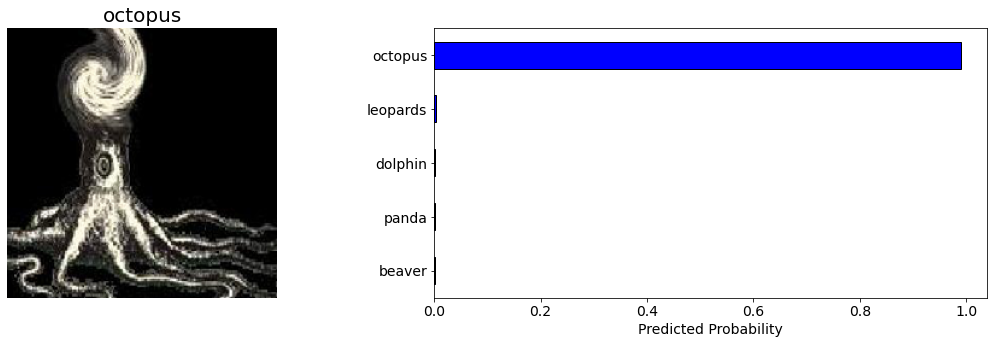

In [47]:
display_prediction(random_test_image(), model, topk=5)

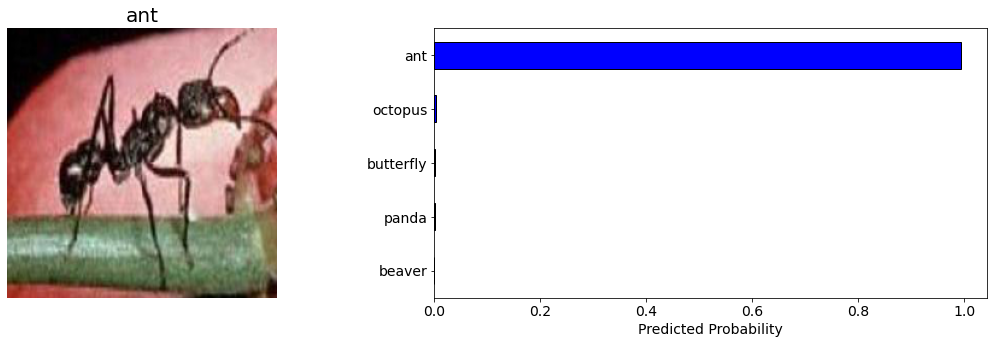

In [48]:
display_prediction(random_test_image(), model, topk=5)

In [49]:
#Testing the accuracy
def accuracy(output, target, topk=(1, )):
    """Compute the topk accuracy(s)"""
    if train_on_gpu:
        output = output.to('cuda')
        target = target.to('cuda')

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # Find the predicted classes and transpose
        _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True)
        pred = pred.t()

        # Determine predictions equal to the targets
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []

        # For each k, find the percentage of correct
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res

In [59]:
testiter = iter(dataloaders['test'])
# Get a batch of testing images and labels
features, targets = next(testiter)
if train_on_gpu:
    results = accuracy(model(features.to('cuda')), targets, topk=(1, 5))
else:
    results = accuracy(model(features), targets, topk=(1, 5))
results

[95.3125, 100.0]

In [68]:
#visualising results

results = pd.DataFrame(top_p, columns=["class"]).merge(cat_df, left_on='class', right_on='category').drop(columns=['category'])

# Plot using seaborn
sns.lmplot(
    y='top1', x='n_train', data=results, height=6)
plt.xlabel('images')
plt.ylabel('Accuracy (%)')
plt.title('Top 1 Accuracy vs Number of Training Images')
plt.ylim(-5, 105)

ValueError: ignored

In [ ]:
print('Category with minimum accuracy.')
results.loc[results['top1'].idxmin]

print('Category with minimum images.')
results.loc[results['n_train'].idxmin]

In [ ]:
sns.lmplot(
    y='top5', x='n_train', data=results, height=6)
plt.xlabel('images')
plt.ylabel('Accuracy (%)')
plt.title('Top 5 Accuracy vs Number of Training Images')
plt.ylim(-5, 105)

In [ ]:
# Weighted column of test images
results['weighted'] = results['n_test'] / results['n_test'].sum()

# Create weighted accuracies
for i in (1, 5):
    results[f'weighted_top{i}'] = results['weighted'] * results[f'top{i}']

# Find final accuracy accounting for frequencies
top1_weighted = results['weighted_top1'].sum()
top5_weighted = results['weighted_top5'].sum()
loss_weighted = (results['weighted'] * results['loss']).sum()

print(f'Final test cross entropy per image = {loss_weighted:.4f}.')
print(f'Final test top 1 weighted accuracy = {top1_weighted:.2f}%')
print(f'Final test top 5 weighted accuracy = {top5_weighted:.2f}%')

In [ ]:
#fucntion to display the predictions for an image

def display_category(model, category, n=4):
    """Display predictions for a category    
    """
    category_results = results.loc[results['class'] == category]
    print(category_results.iloc[:, :6], '/n')

    images = np.random.choice(
        os.listdir(testdir + category + '/'), size=4, replace=False)

    for img in images:
        display_prediction(testdir + category + '/' + img, model, 5)

In [ ]:
display_category(model, 'mandolin')